<a href="https://colab.research.google.com/github/Vineet2107/tensorflow2/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [30]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPool2D, Dense
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [31]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/Getting started with Tensorflow 2 Capstone project/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/Getting started with Tensorflow 2 Capstone project/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [33]:
X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']
X_train.shape, X_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [34]:
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1 , 0)
X_train.shape, X_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

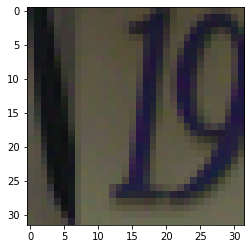

[1]


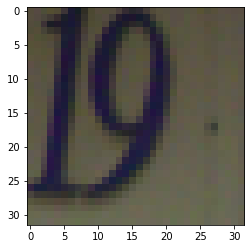

[9]


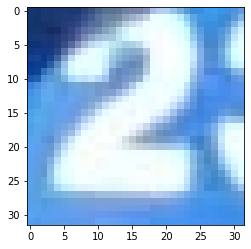

[2]


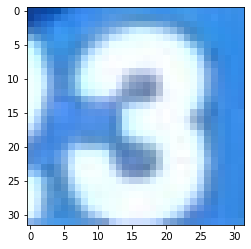

[3]


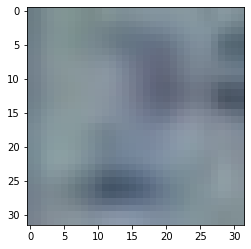

[2]


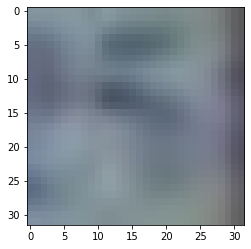

[5]


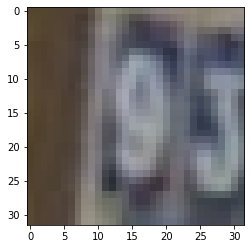

[9]


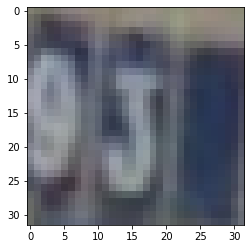

[3]


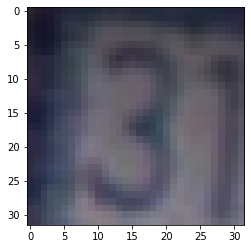

[3]


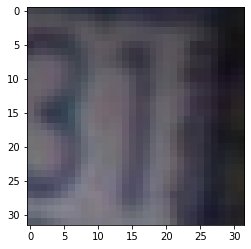

[1]


In [35]:
for i in range(10):
    plt.imshow(X_train[i, :, :, :,])
    plt.show()
    print(y_train[i])

In [36]:
X_train_gs = np.mean(X_train, 3).reshape(73257, 32, 32, 1)/255
X_test_gs = np.mean(X_test,3).reshape(26032, 32,32 ,1)/255
X_train_for_plotting = np.mean(X_train,3)

In [37]:
X_train_gs.shape

(73257, 32, 32, 1)

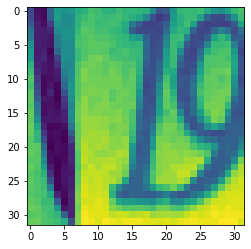

[1]


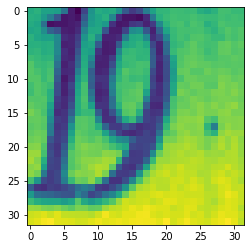

[9]


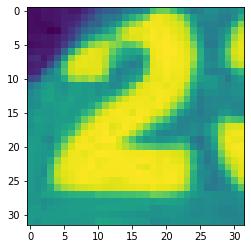

[2]


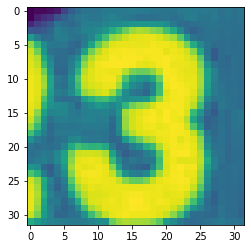

[3]


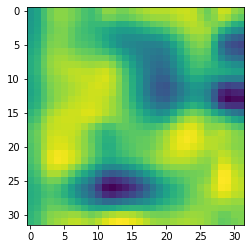

[2]


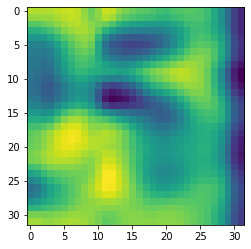

[5]


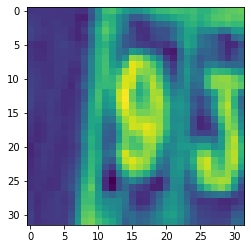

[9]


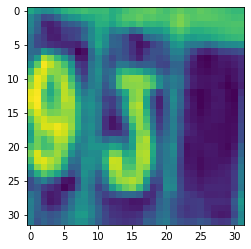

[3]


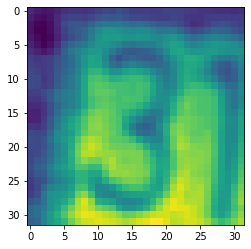

[3]


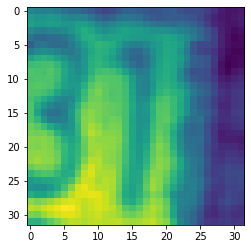

[1]


In [38]:
for i in range(10):
    plt.imshow(X_train_for_plotting[i, :, :,])
    plt.show()
    print(y_train[i])

In [39]:
X_train[0].shape

(32, 32, 3)

In [40]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y_train)
y_train_oh = enc.transform(y_train).toarray()
y_test_oh = enc.transform(y_test).toarray()

In [41]:
y_test_oh[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

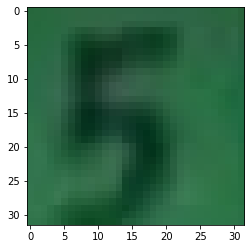

In [42]:
plt.imshow(X_test[0])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(filepath = 'SeqMode_mySeqModel', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)
earlystop = EarlyStopping(patience=5, monitor='loss')

In [44]:
model2 = Sequential([
    Flatten(input_shape=X_train[0].shape),
    Dense(128*4, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

In [45]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train_oh, callbacks=[checkpoint, earlystop], batch_size=128, validation_data=(X_test, y_test_oh), epochs=30)

Epoch 1/30
573/573 [==============================] - 4s 5ms/step - loss: 2.2231 - acc: 0.1911 - val_loss: 2.6148 - val_acc: 0.2039

Epoch 00001: val_loss improved from inf to 2.61482, saving model to SeqMode\mySeqModel
Epoch 2/30
573/573 [==============================] - 3s 5ms/step - loss: 1.7031 - acc: 0.4136 - val_loss: 1.7500 - val_acc: 0.4983

Epoch 00002: val_loss improved from 2.61482 to 1.75003, saving model to SeqMode\mySeqModel
Epoch 3/30
573/573 [==============================] - 3s 5ms/step - loss: 1.4498 - acc: 0.5210 - val_loss: 1.6168 - val_acc: 0.4507

Epoch 00003: val_loss improved from 1.75003 to 1.61675, saving model to SeqMode\mySeqModel
Epoch 4/30
573/573 [==============================] - 2s 4ms/step - loss: 1.3509 - acc: 0.5617 - val_loss: 1.4236 - val_acc: 0.5432

Epoch 00004: val_loss improved from 1.61675 to 1.42362, saving model to SeqMode\mySeqModel
Epoch 5/30
573/573 [==============================] - 3s 5ms/step - loss: 1.2946 - acc: 0.5870 - val_loss: 1

In [46]:
!dir

checkpoint  sample_data				     SeqMode\\mySeqModel.index
gdrive	    SeqMode\\mySeqModel.data-00000-of-00001


Text(0.5, 1.0, 'Loss')

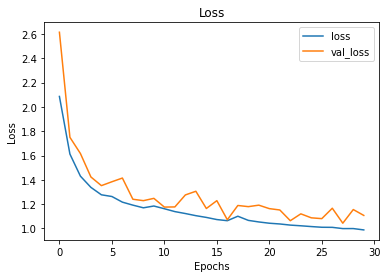

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

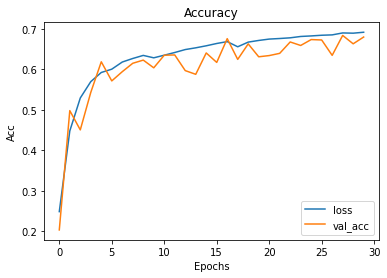

In [48]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_acc'], loc='lower right')
plt.title("Accuracy")

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [49]:
model3 = Sequential([
    Conv2D(filters= 16, kernel_size= 3, activation='relu', input_shape=X_train[0].shape),
    MaxPool2D(pool_size= (3,3), strides=1),
    Conv2D(filters= 32, kernel_size = 3, padding='valid', strides=1, activation='relu'),
    MaxPool2D(pool_size = (1,1), strides = 3),
    BatchNormalization(),
    Conv2D(filters= 32, kernel_size = 3, padding='valid', strides=2, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    Dense(10, activation='softmax')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 32)         

In [50]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [51]:
callback1 = ModelCheckpoint(filepath='CNNweights', save_best_only=True, save_weights_only=True, save_freq=5000,monitor='val_acc')
callback2 = EarlyStopping(monitor='loss',patience=7, verbose=1)

In [52]:
X_train.shape

(73257, 32, 32, 3)

In [29]:
history = model3.fit(X_train, y_train_oh, callbacks=[callback1, callback2], batch_size=256, validation_data=(X_test, y_test_oh), epochs=30)

Epoch 1/30
287/287 [==============================] - 3s 11ms/step - loss: 0.3750 - acc: 0.8901 - val_loss: 0.3273 - val_acc: 0.9057
Epoch 2/30
287/287 [==============================] - 3s 10ms/step - loss: 0.3710 - acc: 0.8907 - val_loss: 0.3817 - val_acc: 0.8893
Epoch 3/30
287/287 [==============================] - 3s 10ms/step - loss: 0.3679 - acc: 0.8902 - val_loss: 0.3278 - val_acc: 0.9085
Epoch 4/30
287/287 [==============================] - 3s 10ms/step - loss: 0.3678 - acc: 0.8909 - val_loss: 0.3198 - val_acc: 0.9087
Epoch 5/30
287/287 [==============================] - 3s 10ms/step - loss: 0.3685 - acc: 0.8918 - val_loss: 0.3472 - val_acc: 0.9018
Epoch 6/30
287/287 [==============================] - 3s 10ms/step - loss: 0.3679 - acc: 0.8911 - val_loss: 0.3026 - val_acc: 0.9148
Epoch 7/30
287/287 [==============================] - 3s 10ms/step - loss: 0.3581 - acc: 0.8935 - val_loss: 0.3448 - val_acc: 0.8995
Epoch 8/30
287/287 [==============================] - 3s 10ms/step - 

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [62]:
model3.load_weights('SeqMode_mySeqModel')

NotFoundError: ignored

In [58]:
import random

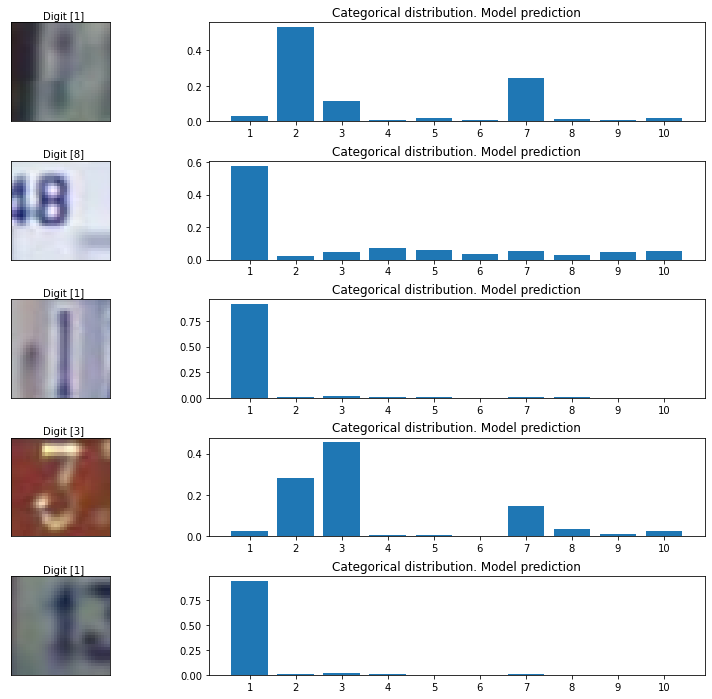

In [59]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model2.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

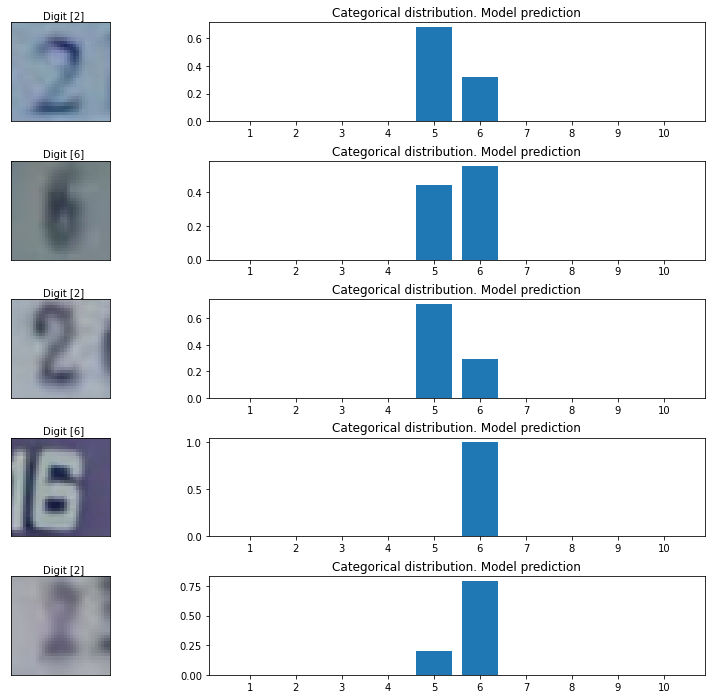

In [60]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model3.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()